# From NDArray to trained model

Based off https://beta.mxnet.io/guide/crash-course/index.html

In [1]:
import mxnet as mx
from mxnet import nd
import numpy as np

import time

NDArray: Numpy-like package to manipulate tensor across compute contexts (CPU / GPU)

In [2]:
a = ((1,2,3),(5,6,7))

In [3]:
x = nd.array(a, ctx=mx.cpu()) #context argument: default to cpu
x


[[ 1.  2.  3.]
 [ 5.  6.  7.]]
<NDArray 2x3 @cpu(0)>

In [4]:
y = nd.array(a, ctx=mx.gpu())
y


[[ 1.  2.  3.]
 [ 5.  6.  7.]]
<NDArray 2x3 @gpu(0)>

As with NumPy, the dimensions of each NDArray are accessible by accessing the .shape attribute. We can also query its size, which is equal to the product of the components of the shape. In addition, .dtype tells the data type of the stored values.

In [5]:
(x.shape, x.size, x.dtype, x.context)

((2, 3), 6, numpy.float32, cpu(0))

## Operations

Similar to numpy

In [6]:
x


[[ 1.  2.  3.]
 [ 5.  6.  7.]]
<NDArray 2x3 @cpu(0)>

In [7]:
x + x


[[  2.   4.   6.]
 [ 10.  12.  14.]]
<NDArray 2x3 @cpu(0)>

In [8]:
x * y.as_in_context(mx.cpu()) #y is on gpu so need to move it on cpu


[[  1.   4.   9.]
 [ 25.  36.  49.]]
<NDArray 2x3 @cpu(0)>

In [9]:
nd.dot(x,x.T)


[[  14.   38.]
 [  38.  110.]]
<NDArray 2x2 @cpu(0)>

**challenge**: Compute the difference between y and x, do the computation on GPU

In [10]:
y - x.as_in_context(mx.gpu())


[[ 0.  0.  0.]
 [ 0.  0.  0.]]
<NDArray 2x3 @gpu(0)>

## Indexing and Assignment

In [11]:
x[1:2,0:2] = 4
x


[[ 1.  2.  3.]
 [ 4.  4.  7.]]
<NDArray 2x3 @cpu(0)>

In [12]:
x[0,:]


[ 1.  2.  3.]
<NDArray 3 @cpu(0)>

**Challenge**: Get the last column of x

In [13]:
x[:,2]


[ 3.  7.]
<NDArray 2 @cpu(0)>

In [14]:
mx.context.num_gpus()

1

## Numpy vs NDArray

In [15]:
b = np.ones((5,5))
b

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.]])

In [16]:
c = nd.array(b)
c


[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
<NDArray 5x5 @cpu(0)>

In [17]:
c.asnumpy() #attention c'est synchronous, donc ca attend le backend et ne fait rien 

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.]], dtype=float32)

Why bother with NDArray? Speed!

Dot product of a 10'000x10'000 matrix in numpy

In [18]:
tic = time.time()
d = np.ones((10000, 10000))
e = np.dot(d, d)
time.time() - tic
#numpy utilise les coeurs virtuels donc se prend un bottleneck en cache. Le htop permet de voir ca. (to crunch)

18.083797454833984

Dot product of a 10'000x10'000 matrix in NDArray on CPU

In [19]:
tic = time.time()
d = nd.ones((10000, 10000), mx.cpu())
e = nd.dot(d, d).wait_to_read()
time.time() - tic

6.625842332839966

~2x speed increase

**Challenge**: Compare numpy vs ndarray on GPU

In [20]:
tic = time.time()
d = nd.ones((10000, 10000), mx.gpu())
e = nd.dot(d, d).wait_to_read()
time.time() - tic
#FAST !!

0.1738419532775879

## Neural Networks

NDArray are used to store the data, feature maps, weights and parameters of neural networks. Now let's see how we can define the layers of our networks!

![](https://media.giphy.com/media/1j9f6wCFelOwzbGyoa/giphy.gif)

In [21]:
from mxnet import nd
from mxnet.gluon import nn

### Network creation

a simple sequential network (LeNet)

![](https://cdn-images-1.medium.com/max/2000/1*1TI1aGBZ4dybR6__DI9dzA.png)

In [22]:
net = nn.HybridSequential()
ctx = mx.cpu()

with net.name_scope():
    # Add a sequence of layers.
    net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'), #on ne donne pas la taille en input
            nn.MaxPool2D(pool_size=2, strides=2),
            nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
            nn.MaxPool2D(pool_size=2, strides=2),
            nn.Dense(120, activation="relu"),
            nn.Dense(84, activation="relu"),
            nn.Dense(10)) ###ici pas d'activation, on mettra le softmax si besoin au calcul du loss
net

HybridSequential(
  (0): Conv2D(None -> 6, kernel_size=(5, 5), stride=(1, 1), Activation(relu))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Dense(None -> 120, Activation(relu))
  (5): Dense(None -> 84, Activation(relu))
  (6): Dense(None -> 10, linear)
)

Initialization, possibility of having different schemes per layer or per parameter type

In [23]:
net.collect_params('.*weight.*').initialize(mx.init.Normal(), ctx=ctx)
net.collect_params('.*bias.*').initialize(mx.init.Uniform(), ctx=ctx)

### Vizualizing the network

In [24]:
shape = (1,1,28,28)

In [25]:
net.summary(nd.ones(shape, ctx=ctx)) #il faut donner un input au réseau sinon la taille d'input n'est pas connue

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 1, 28, 28)               0
        Activation-1   <Symbol hybridsequential0_conv0_relu_fwd>               0
        Activation-2                              (1, 6, 24, 24)               0
            Conv2D-3                              (1, 6, 24, 24)             156
         MaxPool2D-4                              (1, 6, 12, 12)               0
        Activation-5   <Symbol hybridsequential0_conv1_relu_fwd>               0
        Activation-6                             (1, 16, 10, 10)               0
            Conv2D-7                             (1, 16, 10, 10)             880
         MaxPool2D-8                               (1, 16, 5, 5)               0
        Activation-9  <Symbol hybridsequential0_dense0_relu_fwd>               0
       Activation-10        

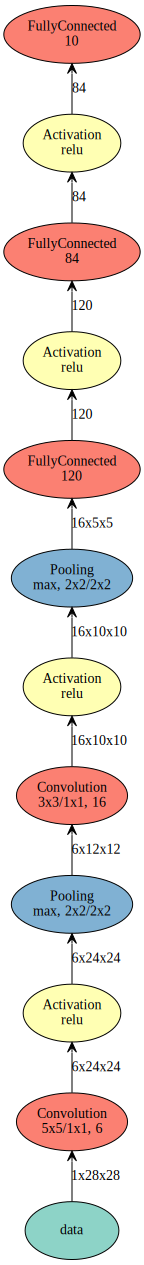

In [59]:
mx.viz.plot_network(net(mx.sym.var('data')), shape={'data': shape}, node_attrs={"shape":"oval","fixedsize":"false"})

## Data

In [26]:
from mxnet import nd, gluon, init, autograd
from mxnet.gluon.data.vision import datasets, transforms

import matplotlib.pyplot as plt

#### Load the raw data

In [27]:
mnist_train = datasets.FashionMNIST(train=True)
mnist_test = datasets.FashionMNIST(train=False)
X, y = mnist_train[0]
('X shape: ', X.shape, 'X dtype', X.dtype, 'y:', y)

('X shape: ', (28, 28, 1), 'X dtype', numpy.uint8, 'y:', 2)

Let's look at the data

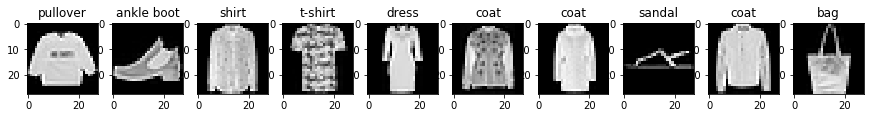

In [28]:
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
X, y = mnist_train[0:10]

_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy(), cmap='gray')
    f.axes.set_title(text_labels[int(yi)])
plt.show()

In order to feed data into a Gluon model, we need to convert the images to the (channel, height, width) format with a floating point data type. It can be done by `transforms.ToTensor`. In addition, we normalize all pixel values with `transforms.Normalize` with the real mean 0.13 and standard deviation 0.31. We chain these two transforms together and apply it to the first element of the data pair, namely the images.

#### Prepare the data using `transforms` 

In [52]:
transformer_augmenter = transforms.Compose([
    transforms.RandomFlipLeftRight(),
    #transforms.RandomLighting(0.1),
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)]) #this should be recomputed if we add some transformation

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

mnist_train_ = mnist_train.transform_first(transformer_augmenter) #lazy transform par defaul, mais possible de mettre lazy=False
mnist_test_ = mnist_test.transform_first(transformer)

#### Creating the data loaders

In [53]:
batch_size = 256

train_data = gluon.data.DataLoader(mnist_train_, batch_size=batch_size, shuffle=True, num_workers=4)
test_data = gluon.data.DataLoader(mnist_test_, batch_size=batch_size, shuffle=False, num_workers=4)

The returned train_data is an iterable object that yields batches of images and labels pairs.

In [54]:
for data, label in train_data:
    print(data.shape, label.shape)
    break

(256, 1, 28, 28) (256,)


## Loss and Optimization

Besides the neural network, we need to define the loss function and optimization method for training. We will use standard softmax cross entropy loss for classification problems. It first performs softmax on the output to obtain the predicted probability, and then compares the label with the cross entropy.

In [55]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

The optimization method we pick is the standard stochastic gradient descent with constant learning rate of 0.1.

In [56]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.002}) #pour freeze des layers ne pas les mettres dans le collect param (raccourci)
#trainer = gluon.Trainer(net[0:3].collect_params(), 'adam', {'learning_rate': 0.001}) #method pour entrainer certains layers

## Training the network

We hybridize the network for performance and portability (sacrificing some flexibility and debuggability)

In [57]:
net.hybridize() #pas clair du tout

In [58]:
def run_training():
    
    epochs = 20

    for epoch in range(epochs):
        train_loss = 0.
        tic = time.time()
        train_acc, test_acc =  mx.metric.Accuracy(), mx.metric.Accuracy()

        for i, (data, label) in enumerate(train_data):
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # forward + backward
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()

            # update parameters
            trainer.step(batch_size)

            # calculate training metrics
            train_loss += loss.mean().asscalar()
            train_acc.update(label, output)

        # calculate validation accuracy
        for data, label in test_data:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            pred = net(data)
            test_acc.update(label, pred)

        print("Epoch %d: loss %.3f, test acc %.3f, train acc %.3f, in %.1f sec" % (
                epoch, train_loss/(i+1), test_acc.get()[1], train_acc.get()[1], time.time()-tic))

In [89]:
%%time
run_training()

Epoch 0: loss 0.209, test acc 0.906, train acc 0.920, in 2.4 sec
Epoch 1: loss 0.193, test acc 0.907, train acc 0.927, in 2.5 sec


KeyboardInterrupt: 

## Training on GPU

In [59]:
ctx = mx.gpu()
net.initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.004})
net.cast('float32')

In [60]:
%%time
run_training()

Epoch 0: loss 0.574, test acc 0.832, train acc 0.787, in 2.6 sec
Epoch 1: loss 0.370, test acc 0.876, train acc 0.864, in 2.6 sec
Epoch 2: loss 0.332, test acc 0.881, train acc 0.877, in 2.6 sec
Epoch 3: loss 0.305, test acc 0.888, train acc 0.886, in 2.7 sec
Epoch 4: loss 0.287, test acc 0.888, train acc 0.892, in 2.6 sec
Epoch 5: loss 0.273, test acc 0.892, train acc 0.898, in 2.5 sec
Epoch 6: loss 0.266, test acc 0.897, train acc 0.901, in 2.7 sec
Epoch 7: loss 0.253, test acc 0.899, train acc 0.906, in 2.6 sec
Epoch 8: loss 0.248, test acc 0.902, train acc 0.907, in 2.6 sec
Epoch 9: loss 0.240, test acc 0.900, train acc 0.910, in 2.6 sec
Epoch 10: loss 0.230, test acc 0.904, train acc 0.913, in 2.6 sec
Epoch 11: loss 0.227, test acc 0.905, train acc 0.914, in 2.5 sec
Epoch 12: loss 0.224, test acc 0.906, train acc 0.916, in 2.6 sec
Epoch 13: loss 0.213, test acc 0.900, train acc 0.919, in 2.6 sec
Epoch 14: loss 0.213, test acc 0.906, train acc 0.920, in 2.6 sec
Epoch 15: loss 0.213

**Challenge**: Improve the test accuracy by at least 2%